Script starting...

Loading stock data: 005930.KS, 005380.KS, ^KS11, 035720.KS, 035420.KS, 000660.KS (2022-01-01 ~ 2025-06-04)


[*********************100%***********************]  6 of 6 completed



Creating integrated dataset and calculating indicators...

--- Individual Event Analysis & Visualization ---


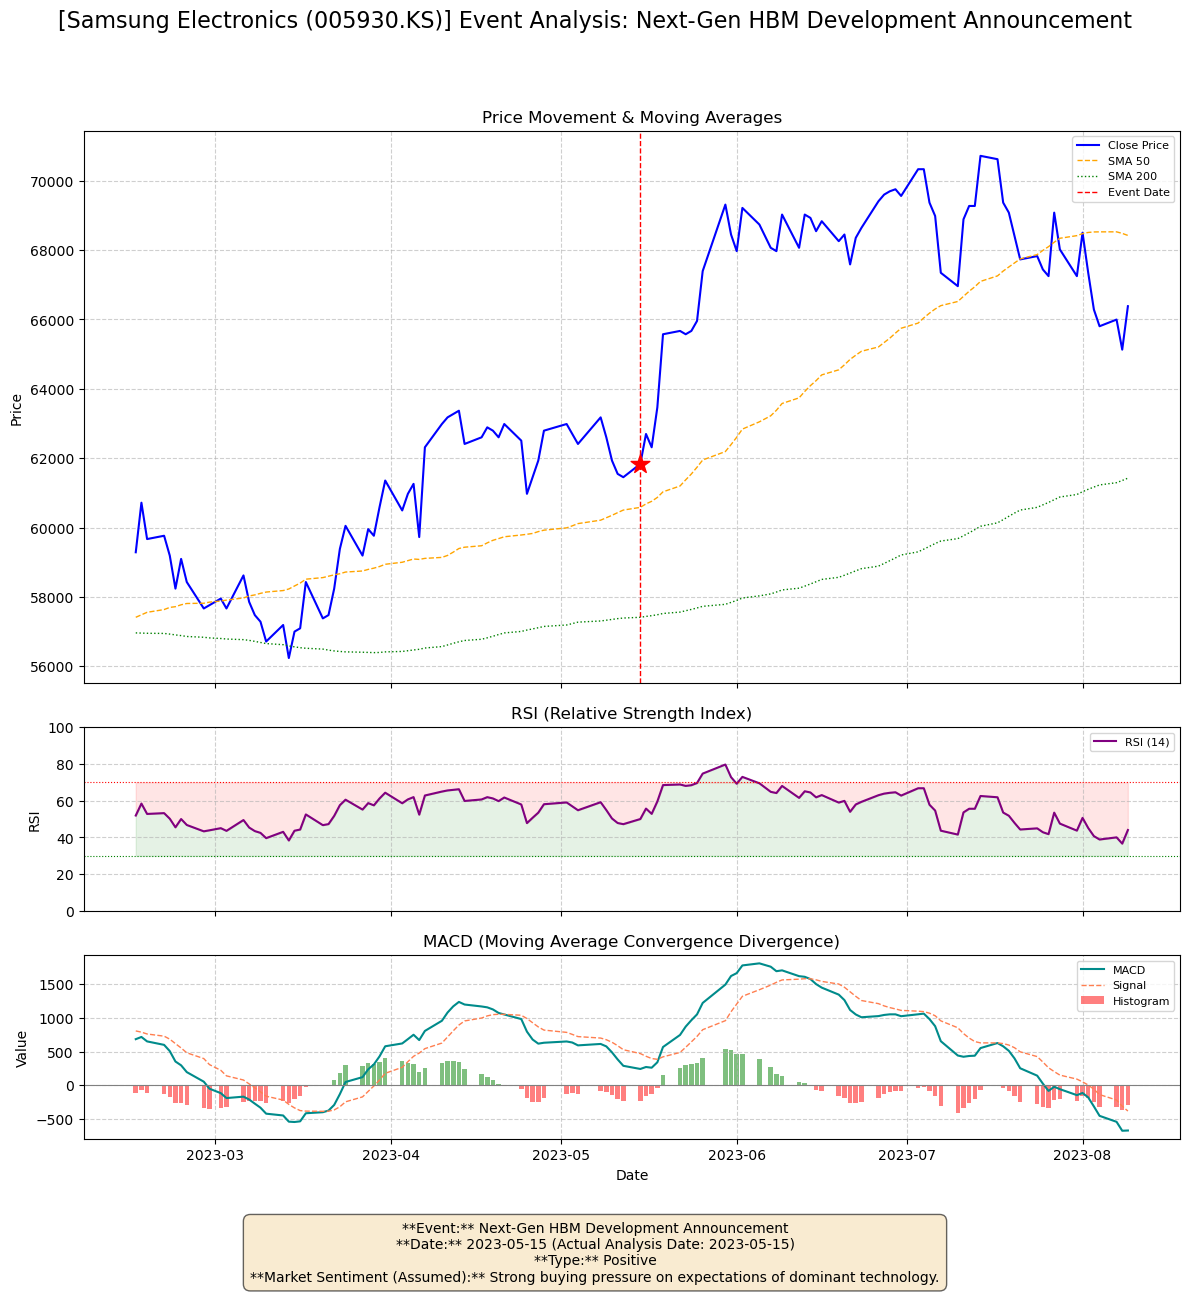

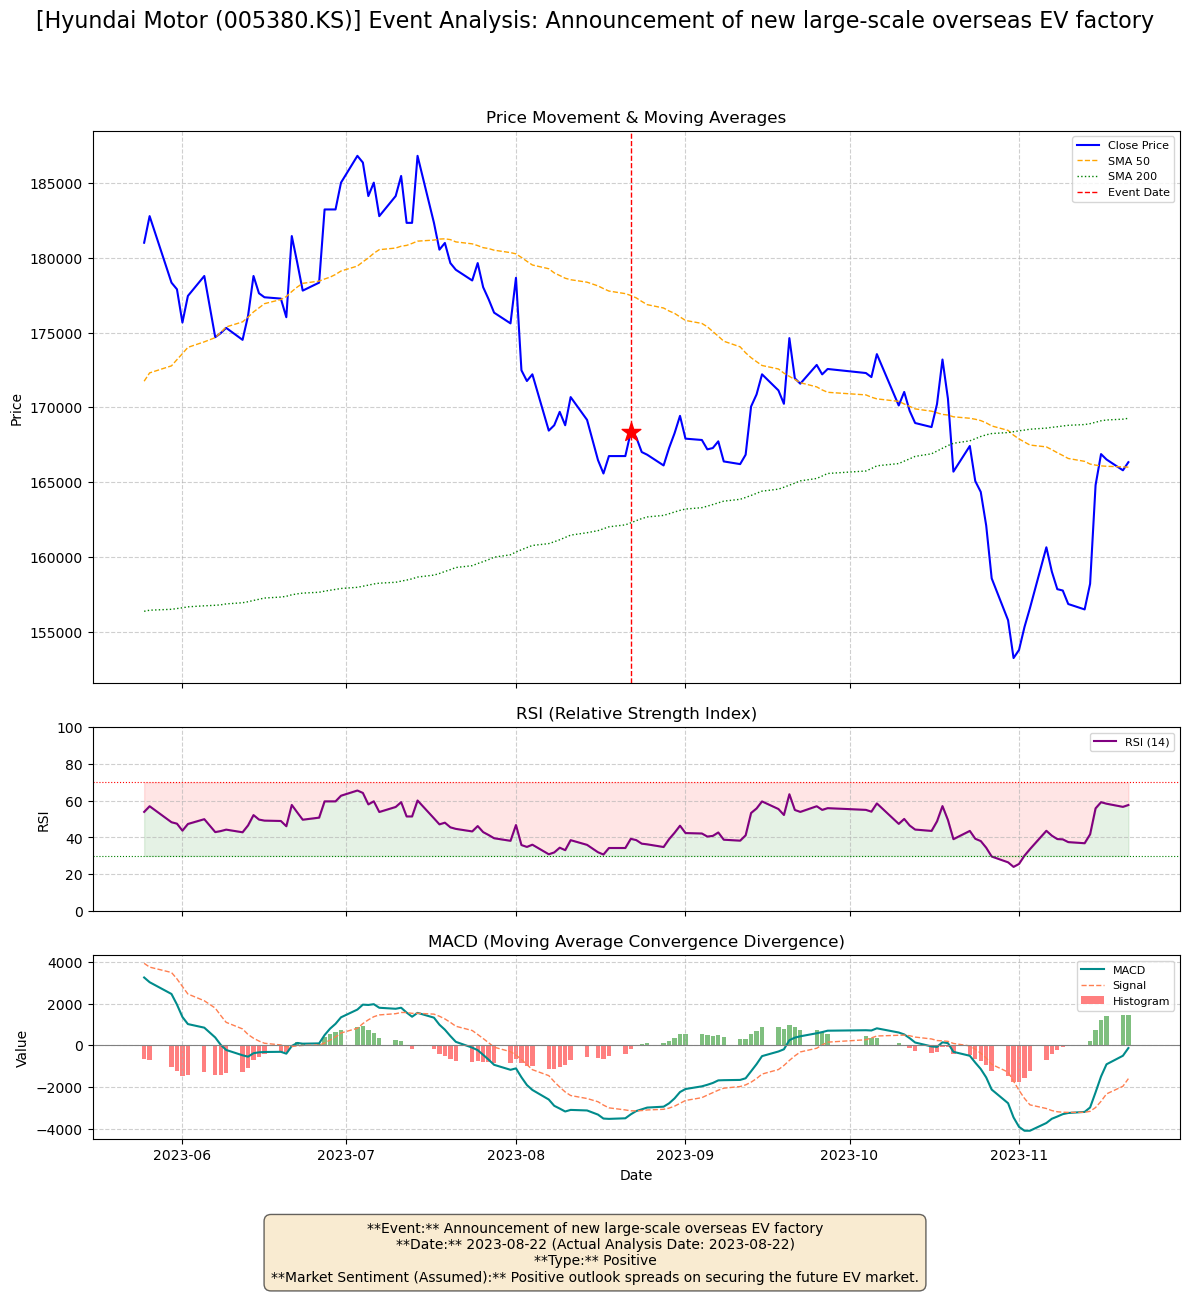

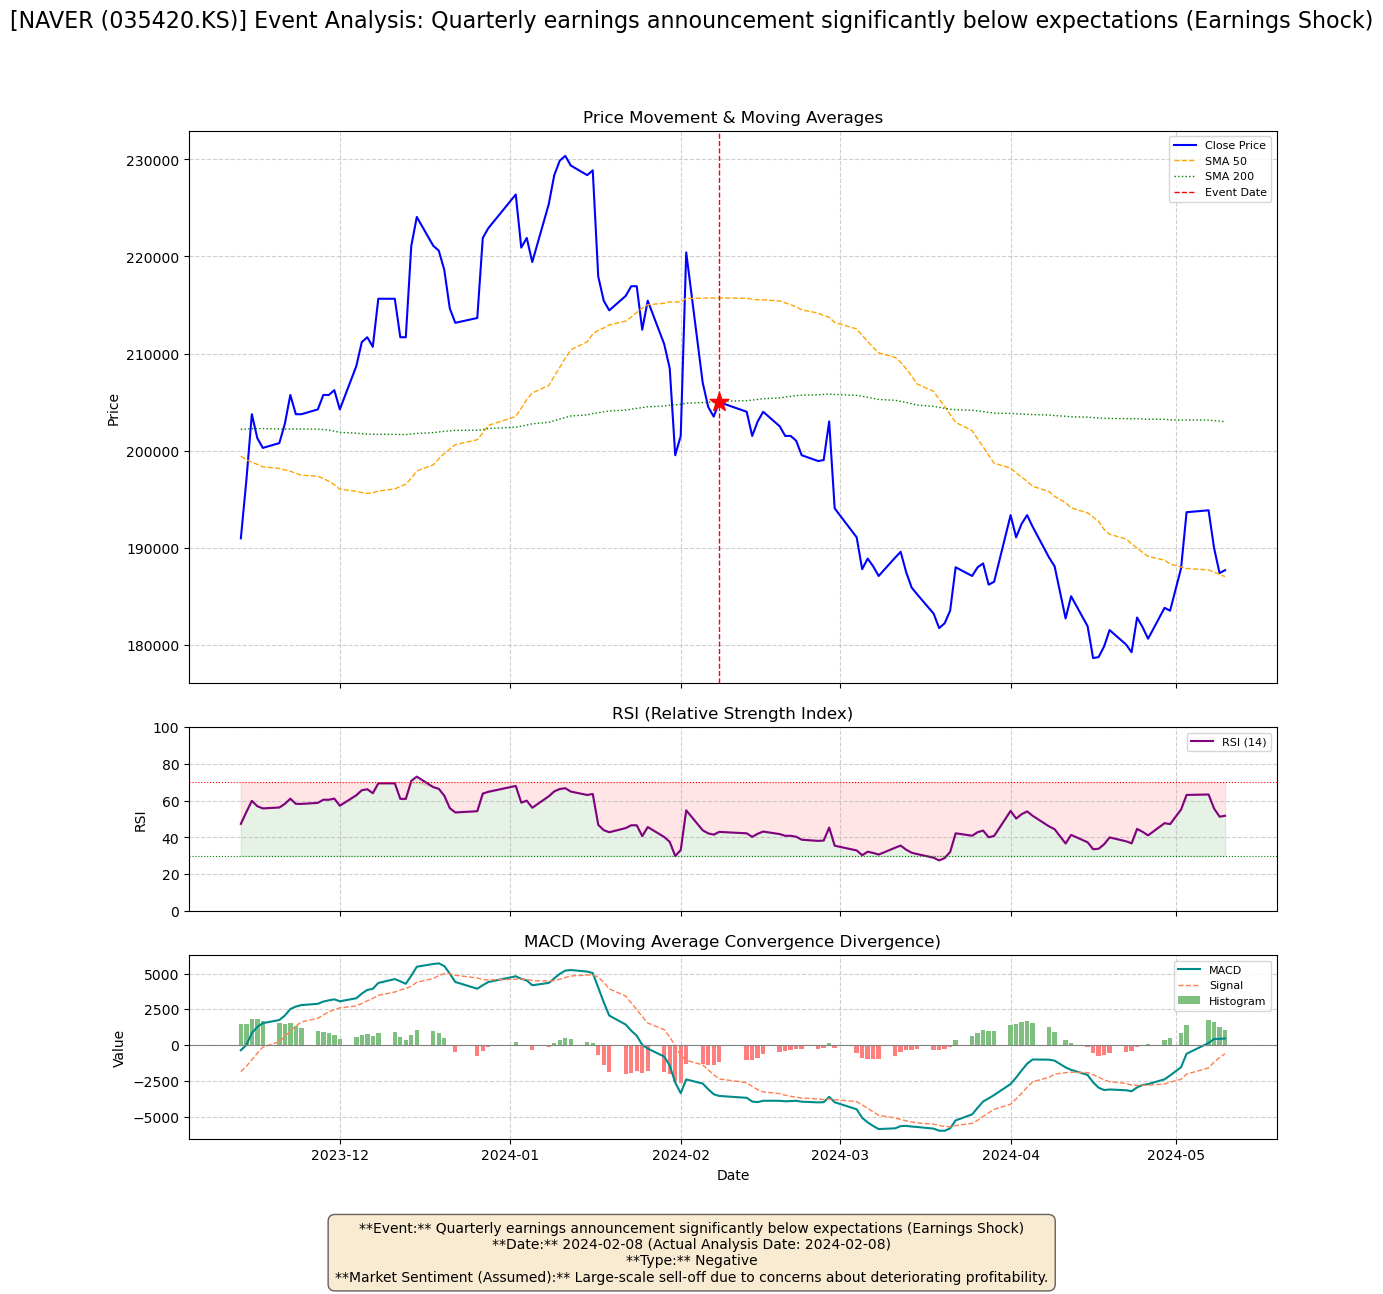

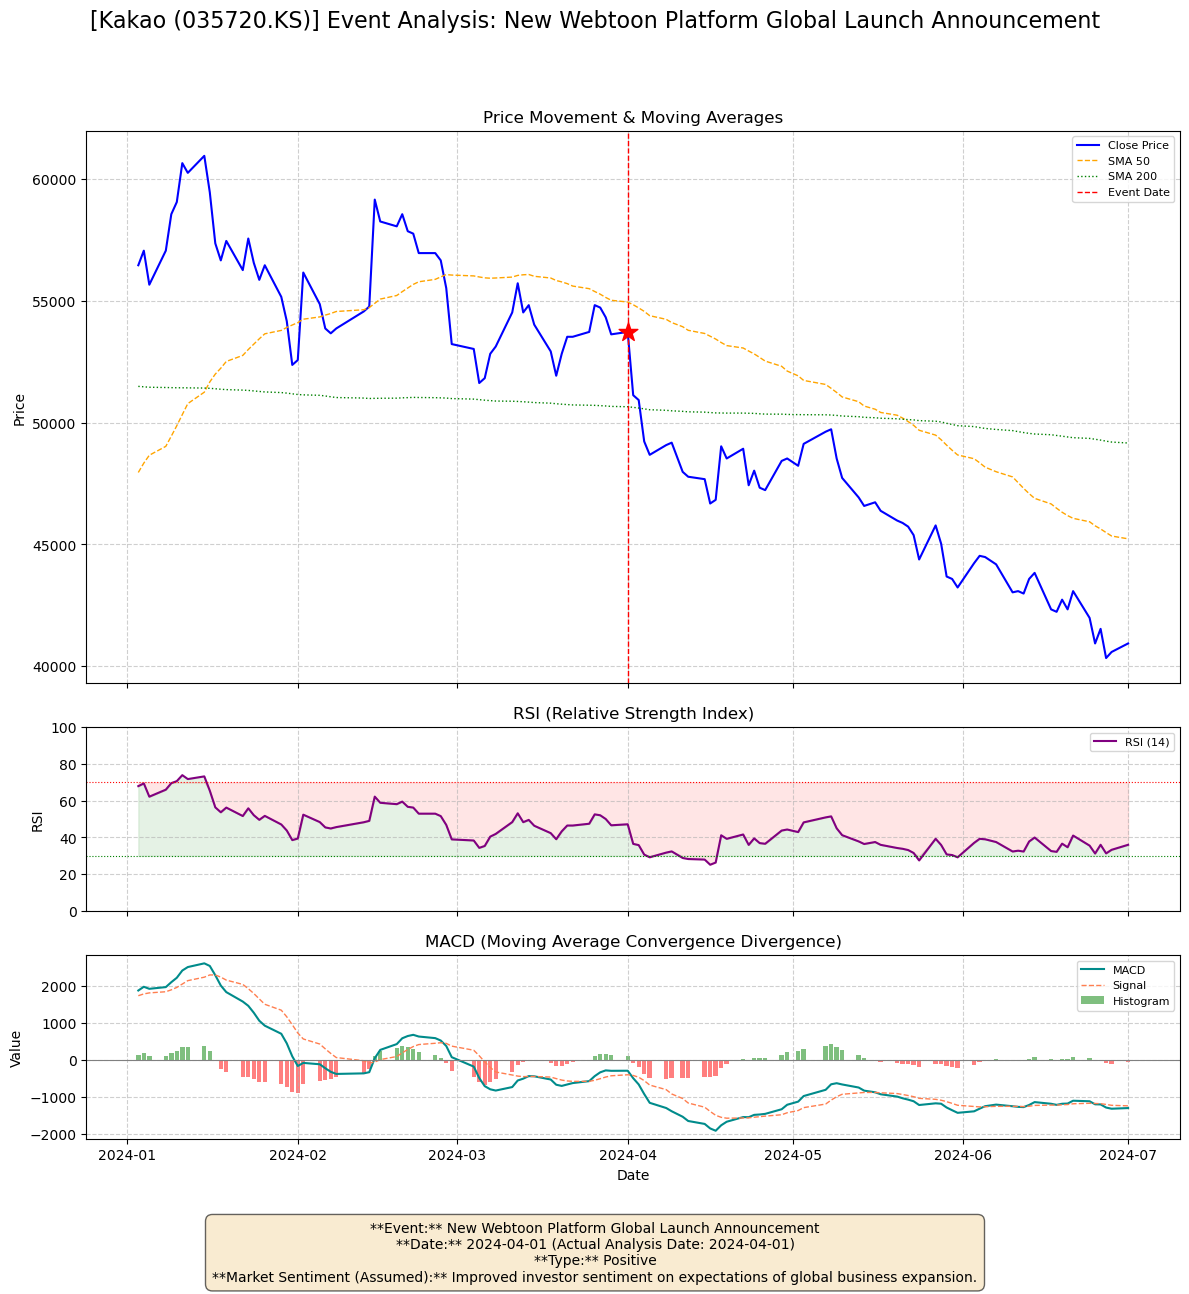

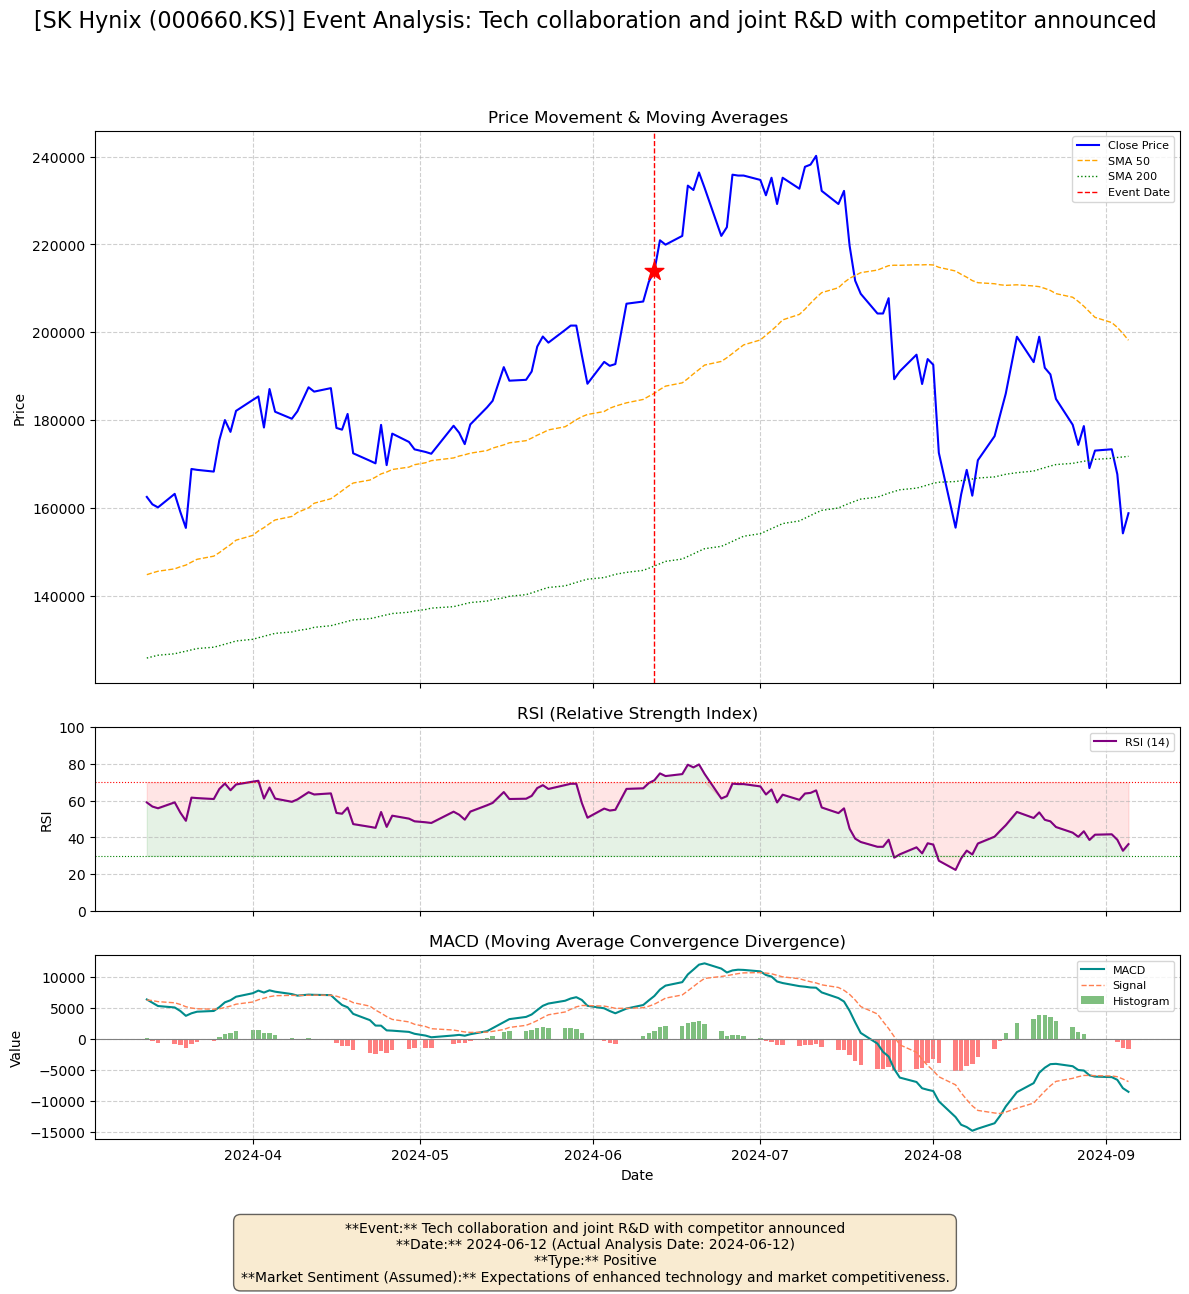


Running backtest...

--- Performance Metrics ---
  CAGR: 0.0285
  Volatility: 0.0881
  SharpeRatio: 0.3240
  MDD: -0.1212
  Beta: 0.0529
  Alpha_daily: 0.0001
  Alpha_annual: 0.0337


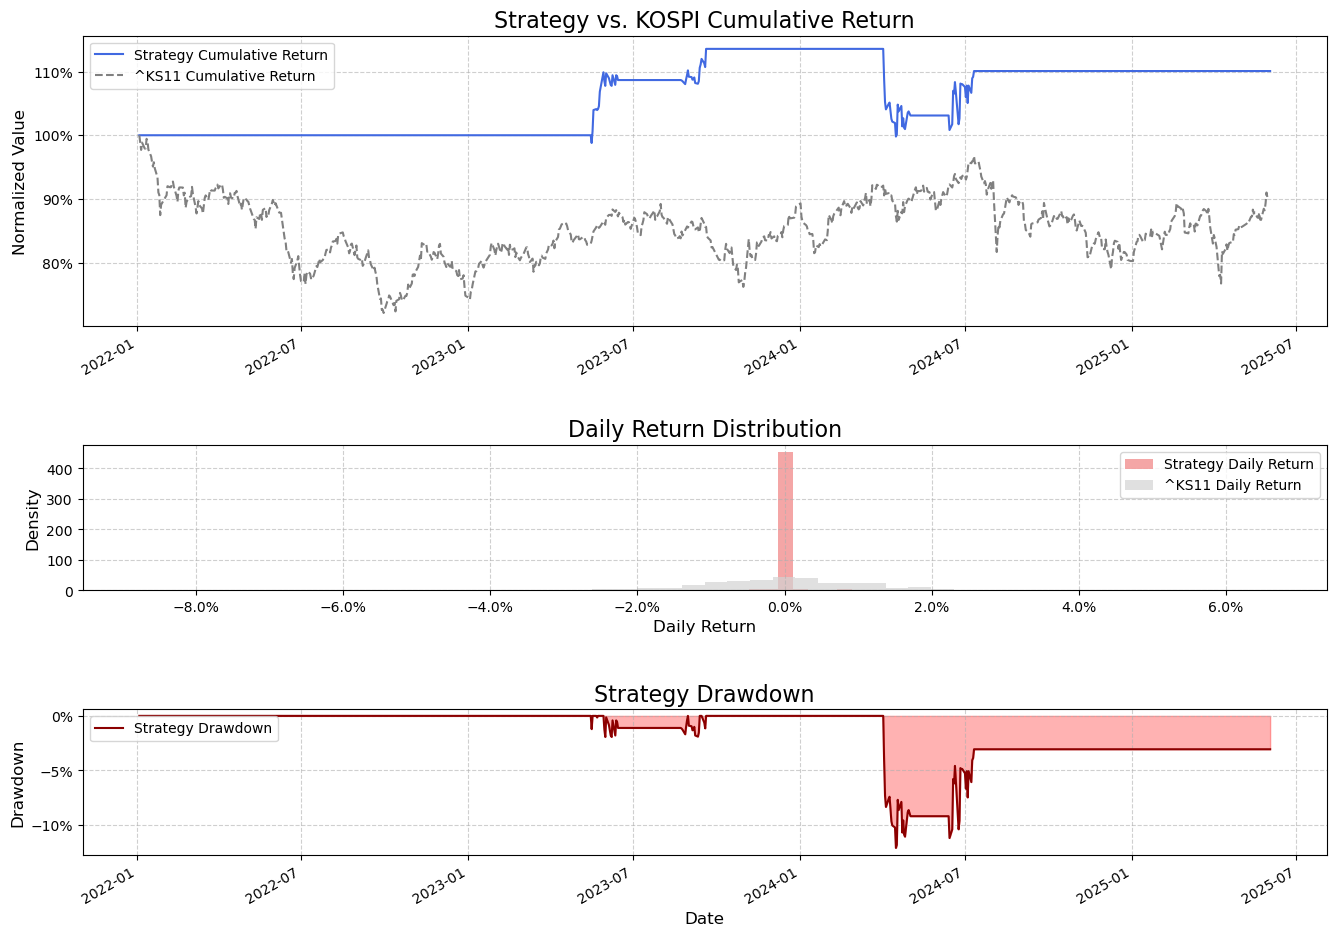

Script finished.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import sys

# Korean font settings are removed to use default English fonts.
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

# --- 0. Settings ---
START_DATE = "2022-01-01" # Adjusted start date to secure sufficient past data
END_DATE = datetime.now().strftime("%Y-%m-%d") # To the current date

# Virtual event definitions
# Please note that stock price movements may differ based on actual dates and event details.
EVENTS = [
    {
        'id': 'E001',
        'company': 'Samsung Electronics',
        'ticker': '005930.KS',
        'date': '2023-05-15',
        'description': 'Next-Gen HBM Development Announcement',
        'type': 'positive', # Positive event
        'market_sentiment': 'Strong buying pressure on expectations of dominant technology.'
    },
    {
        'id': 'E002',
        'company': 'Hyundai Motor',
        'ticker': '005380.KS',
        'date': '2023-08-22',
        'description': 'Announcement of new large-scale overseas EV factory',
        'type': 'positive',
        'market_sentiment': 'Positive outlook spreads on securing the future EV market.'
    },
    {
        'id': 'E003',
        'company': 'NAVER',
        'ticker': '035420.KS',
        'date': '2024-02-08',
        'description': 'Quarterly earnings announcement significantly below expectations (Earnings Shock)',
        'type': 'negative', # Negative event (excluded from backtesting)
        'market_sentiment': 'Large-scale sell-off due to concerns about deteriorating profitability.'
    },
    {
        'id': 'E004',
        'company': 'Kakao',
        'ticker': '035720.KS',
        'date': '2024-04-01',
        'description': 'New Webtoon Platform Global Launch Announcement',
        'type': 'positive',
        'market_sentiment': 'Improved investor sentiment on expectations of global business expansion.'
    },
    {
        'id': 'E005',
        'company': 'SK Hynix',
        'ticker': '000660.KS',
        'date': '2024-06-12',
        'description': 'Tech collaboration and joint R&D with competitor announced',
        'type': 'positive',
        'market_sentiment': 'Expectations of enhanced technology and market competitiveness.'
    },
]

# List of all tickers required for backtesting
ALL_TICKERS_FOR_DOWNLOAD = list(set([event['ticker'] for event in EVENTS] + ['^KS11']))
KOSPI_TICKER = "^KS11"

# --- 2. Data Collection Module ---
def get_stock_data(tickers, start_date, end_date):
    """Fetches stock price data from Yahoo Finance for the specified tickers."""
    print(f"\nLoading stock data: {', '.join(tickers)} ({start_date} ~ {end_date})")

    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, actions=False, progress=True)

    if data.empty:
        print("Warning: Failed to retrieve stock data. Returning an empty DataFrame.")
        return pd.DataFrame()

    adj_close_data = pd.DataFrame()

    # Check and handle data column structure
    if isinstance(data.columns, pd.MultiIndex):
        for ticker in tickers:
            if ('Close', ticker) in data.columns:
                temp_df = data['Close'][ticker].to_frame()
                temp_df.columns = [f'{ticker}_Close']
                # We also need 'Open' prices, so let's fetch them too.
                if ('Open', ticker) in data.columns:
                    temp_df[f'{ticker}_Open'] = data['Open'][ticker]
                adj_close_data = pd.concat([adj_close_data, temp_df], axis=1)
            else:
                print(f"Warning: 'Close' data not found for {ticker}.")
    elif 'Close' in data.columns: # For a single ticker request
        if len(tickers) == 1:
            temp_df = data[['Close']].copy()
            temp_df.columns = [f'{tickers[0]}_Close']
            if 'Open' in data.columns:
                temp_df[f'{tickers[0]}_Open'] = data['Open']
            adj_close_data = pd.concat([adj_close_data, temp_df], axis=1)
        else: # Abnormal case: multiple tickers requested but returned as SingleIndex
            print("Warning: Multiple tickers were requested, but data was returned in a single-ticker format. Data processing may not be consistent.")
            return pd.DataFrame()
    else:
        print("Warning: Could not retrieve 'Close' prices. Returning an empty DataFrame.")
        return pd.DataFrame()

    if not adj_close_data.empty:
        adj_close_data.index = pd.to_datetime(adj_close_data.index)
        adj_close_data = adj_close_data.sort_index()

    return adj_close_data

# --- 3. Technical Indicator Calculation Module ---
def calculate_technical_indicators(price_df, ticker):
    """Calculates technical indicators for a single ticker."""
    df = price_df.copy()
    close_col = f'{ticker}_Close'

    if close_col not in df.columns or df[close_col].isnull().all():
        print(f"Warning: Close price data for {ticker} is missing or empty. Cannot calculate technical indicators.")
        return pd.DataFrame(index=df.index, columns=[])

    price_series = df[close_col].dropna()
    if price_series.empty:
        print(f"Warning: All price data for {ticker} are NaN. Cannot calculate technical indicators.")
        return pd.DataFrame(index=df.index, columns=[])

    temp_ta_df = pd.DataFrame(index=df.index)

    # SMA
    temp_ta_df[f'{ticker}_SMA50'] = ta.sma(price_series, length=50, append=False)
    temp_ta_df[f'{ticker}_SMA200'] = ta.sma(price_series, length=200, append=False)

    # MACD
    macd_result = ta.macd(price_series, append=False)
    if macd_result is not None and not macd_result.empty:
        # Dynamically find column names as they might change with pandas_ta versions
        macd_cols = [col for col in macd_result.columns if 'MACD_' in col and '_h' not in col and '_s' not in col]
        signal_cols = [col for col in macd_result.columns if 'MACDs_' in col]
        histogram_cols = [col for col in macd_result.columns if 'MACDh_' in col]

        if macd_cols:
            temp_ta_df[f'{ticker}_MACD'] = macd_result[macd_cols[0]]
        if signal_cols:
            temp_ta_df[f'{ticker}_MACD_Signal'] = macd_result[signal_cols[0]]
        if histogram_cols:
            temp_ta_df[f'{ticker}_MACD_Hist'] = macd_result[histogram_cols[0]] # Also save the histogram for use

    # RSI
    temp_ta_df[f'{ticker}_RSI'] = ta.rsi(price_series, length=14, append=False)

    return temp_ta_df.reindex(df.index)

# --- 4. Integrated Dataset Creation ---
def create_integrated_dataframe(all_prices):
    """
    Integrates price data for all stocks and adds technical indicators to create the final DataFrame.
    """
    print("\nCreating integrated dataset and calculating indicators...")

    df_merged = all_prices.copy()

    for ticker in ALL_TICKERS_FOR_DOWNLOAD:
        close_col = f'{ticker}_Close'
        if close_col in df_merged.columns and not df_merged[close_col].isnull().all():
            # Calculate and merge technical indicators for each stock
            temp_stock_df = df_merged[[close_col]].copy()
            ta_df = calculate_technical_indicators(temp_stock_df, ticker)
            if not ta_df.empty:
                df_merged = pd.concat([df_merged, ta_df], axis=1)
        else:
            print(f"Warning: Skipping technical indicator calculation for {ticker} due to insufficient data.")

    df_merged = df_merged.sort_index()

    # Re-index based on business days
    # Use only the business days from the stock data's index
    first_valid_index = df_merged.dropna(how='all').index.min()
    last_valid_index = df_merged.dropna(how='all').index.max()

    if first_valid_index is None or last_valid_index is None:
        print("Warning: Could not find a valid data range. Cannot create integrated dataset."); return pd.DataFrame()

    business_days = pd.bdate_range(start=first_valid_index, end=last_valid_index)
    df_merged = df_merged.reindex(business_days).dropna(how='all')

    df_merged.ffill(inplace=True)
    df_merged.bfill(inplace=True)

    if len(df_merged) < 100: # Adjust minimum data days (200 needed for TA, but 100 might work for backtesting)
        print(f"Warning: The integrated dataset has {len(df_merged)} days of valid data, which may not be sufficient for backtesting (at least 100 days recommended).")

    return df_merged

# --- 5. Event Analysis and Visualization ---
def analyze_and_plot_event(df_data, event_info, days_around_event=60):
    """
    Analyzes and visualizes stock price movement and technical indicators for a single event.
    """
    event_date = pd.to_datetime(event_info['date'])
    ticker = event_info['ticker']
    company = event_info['company']
    description = event_info['description']
    event_type = event_info['type']
    market_sentiment = event_info['market_sentiment']

    # If the event date is not in df_data.index, find the nearest date
    event_idx_loc = df_data.index.searchsorted(event_date)

    if event_idx_loc >= len(df_data.index): # If event date is after the last data point
        event_idx = len(df_data.index) - 1
    elif event_idx_loc == 0: # If event date is before the first data point
        event_idx = 0
    else: # If event date is within the data range
        prev_date = df_data.index[event_idx_loc - 1]
        next_date = df_data.index[event_idx_loc]
        if abs(event_date - prev_date) < abs(event_date - next_date):
            event_idx = event_idx_loc - 1
        else:
            event_idx = event_idx_loc

    # Actual event date to be used (the one present in df_data.index)
    actual_event_date_in_df = df_data.index[event_idx]

    # Calculate start/end index for plotting
    start_plot_idx = max(0, event_idx - days_around_event)
    end_plot_idx = min(len(df_data) - 1, event_idx + days_around_event)

    plot_df = df_data.iloc[start_plot_idx : end_plot_idx + 1].copy()

    if plot_df.empty:
        print(f"Warning: Data range for analyzing {company} event ({event_info['date']}) is empty. Skipping.")
        return

    close_col = f'{ticker}_Close'
    open_col = f'{ticker}_Open'
    sma50_col = f'{ticker}_SMA50'
    sma200_col = f'{ticker}_SMA200'
    rsi_col = f'{ticker}_RSI'
    macd_col = f'{ticker}_MACD'
    macd_signal_col = f'{ticker}_MACD_Signal'
    macd_hist_col = f'{ticker}_MACD_Hist' # Add histogram column

    # Skip if required columns are missing
    required_cols = [close_col]
    if not all(col in plot_df.columns for col in required_cols):
        print(f"Warning: Required data columns for analyzing {ticker} event are missing ({close_col}, etc).")
        return

    # Create plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1, 1]})
    fig.suptitle(f"[{company} ({ticker})] Event Analysis: {description}", fontsize=16, y=1.02)

    # 1. Price and Moving Averages
    axes[0].plot(plot_df.index, plot_df[close_col], label='Close Price', color='blue', lw=1.5)
    if sma50_col in plot_df.columns:
        axes[0].plot(plot_df.index, plot_df[sma50_col], label='SMA 50', color='orange', ls='--', lw=1)
    if sma200_col in plot_df.columns:
        axes[0].plot(plot_df.index, plot_df[sma200_col], label='SMA 200', color='green', ls=':', lw=1)

    # Mark the event date
    # Use the 'closest' event date that exists in the dataframe
    if actual_event_date_in_df in plot_df.index:
        axes[0].axvline(actual_event_date_in_df, color='red', linestyle='--', lw=1, label='Event Date')
        axes[0].scatter(actual_event_date_in_df, plot_df.loc[actual_event_date_in_df][close_col],
                        color='red', marker='*', s=200, zorder=5) # Mark event date close price with a star

    axes[0].set_title(f"Price Movement & Moving Averages", fontsize=12)
    axes[0].set_ylabel("Price", fontsize=10)
    axes[0].legend(fontsize=8)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # 2. RSI
    if rsi_col in plot_df.columns and not plot_df[rsi_col].isnull().all():
        axes[1].plot(plot_df.index, plot_df[rsi_col], label='RSI (14)', color='purple', lw=1.5)
        axes[1].axhline(70, color='red', linestyle=':', lw=0.8)
        axes[1].axhline(30, color='green', linestyle=':', lw=0.8)
        axes[1].fill_between(plot_df.index, 70, plot_df[rsi_col].clip(upper=70), color='red', alpha=0.1)
        axes[1].fill_between(plot_df.index, 30, plot_df[rsi_col].clip(lower=30), color='green', alpha=0.1)
        axes[1].set_title("RSI (Relative Strength Index)", fontsize=12)
        axes[1].set_ylabel("RSI", fontsize=10)
        axes[1].set_ylim(0, 100)
        axes[1].legend(fontsize=8)
        axes[1].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[1].set_visible(False) # Hide if no RSI data

    # 3. MACD
    if macd_col in plot_df.columns and macd_signal_col in plot_df.columns and macd_hist_col in plot_df.columns:
        axes[2].plot(plot_df.index, plot_df[macd_col], label='MACD', color='darkcyan', lw=1.5)
        axes[2].plot(plot_df.index, plot_df[macd_signal_col], label='Signal', color='coral', ls='--', lw=1)

        # MACD Histogram (green if positive, red if negative)
        axes[2].bar(plot_df.index, plot_df[macd_hist_col],
                    color=['green' if x > 0 else 'red' for x in plot_df[macd_hist_col]], alpha=0.5, label='Histogram')

        axes[2].axhline(0, color='gray', linestyle='-', lw=0.8)
        axes[2].set_title("MACD (Moving Average Convergence Divergence)", fontsize=12)
        axes[2].set_xlabel("Date", fontsize=10)
        axes[2].set_ylabel("Value", fontsize=10)
        axes[2].legend(fontsize=8)
        axes[2].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[2].set_visible(False) # Hide if no MACD data

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust for suptitle

    # Display event details in a text box
    event_text = (
        f"**Event:** {description}\n"
        f"**Date:** {event_info['date']} (Actual Analysis Date: {actual_event_date_in_df.strftime('%Y-%m-%d')})\n" # Specify actual analysis date
        f"**Type:** {'Positive' if event_type == 'positive' else 'Negative'}\n"
        f"**Market Sentiment (Assumed):** {market_sentiment}"
    )
    plt.figtext(0.5, 0.01, event_text, ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.5", fc="wheat", ec="black", lw=1, alpha=0.6))
    plt.show()


# --- 6. Investment Strategy and Backtesting Module ---
def run_backtest(df_data, events, initial_capital=100000000):
    """
    Backtests an event-driven trading strategy.
    Strategy: Buy at the opening price on the next trading day after a positive event, and sell after 20 trading days.
    """
    print("\nRunning backtest...")
    if df_data.empty:
        print("Error: Backtesting data is empty. Cannot run backtest."); return None, {}

    capital = initial_capital
    portfolio_val = pd.Series(index=df_data.index, dtype=float)

    # Current positions (ticker: shares)
    current_holdings = {}

    trades = [] # Trade log

    if not df_data.index.empty:
        portfolio_val.iloc[0] = initial_capital

    # Event queue for executing trades (event date, ticker, buy date)
    event_buy_signals = []

    # Filter for positive events only
    positive_events = [e for e in events if e['type'] == 'positive']

    # Map event dates to the DataFrame index (find the nearest business day)
    mapped_events = []
    for event in positive_events:
        event_date_dt = pd.to_datetime(event['date'])

        # === Modified part: Find the next business day directly ===
        actual_event_date = None
        buy_date = None

        # If the event date is not in df_data.index, find the nearest next business day
        event_idx_loc = df_data.index.searchsorted(event_date_dt)
        if event_idx_loc < len(df_data.index):
            actual_event_date = df_data.index[event_idx_loc] # Actual date in the dataframe corresponding to the event

            # Find buy date (the next trading day after the event)
            buy_date_idx = df_data.index.get_loc(actual_event_date) + 1
            if buy_date_idx < len(df_data):
                buy_date = df_data.index[buy_date_idx]
            else:
                print(f"Warning: Buy date for {event['company']} event ({event['date']}) is out of data range. It will not be included in the backtest.")
                continue # To the next event

        if actual_event_date and buy_date: # If both actual event date and buy date are valid
            mapped_events.append({
                'ticker': event['ticker'],
                'event_date': actual_event_date,
                'buy_date': buy_date,
                'sell_after_days': 20 # Sell after holding for 20 trading days
            })
        else:
            print(f"Warning: Could not find corresponding data for {event['company']} event ({event['date']}) or buy date is invalid. It will not be included in the backtest.")

    for date_idx, current_date in enumerate(df_data.index):
        # Update portfolio value
        current_portfolio_value = capital
        for ticker, shares in current_holdings.items():
            close_price_col = f'{ticker}_Close'
            # Corrected this line to use the correct variable name
            if close_price_col in df_data.columns and pd.notna(df_data.loc[current_date, close_price_col]):
                current_portfolio_value += shares * df_data.loc[current_date, close_price_col]
            else:
                pass
        portfolio_val.loc[current_date] = current_portfolio_value

        # Buy logic (buy at open on the day after the event)
        for event in mapped_events:
            if current_date == event['buy_date']:
                ticker = event['ticker']
                open_price_col = f'{ticker}_Open'
                if open_price_col in df_data.columns and pd.notna(df_data.loc[current_date, open_price_col]) and df_data.loc[current_date, open_price_col] > 0:
                    buy_price = df_data.loc[current_date, open_price_col]

                    if capital > 0:
                        # Simple strategy: don't buy more if already holding
                        if ticker not in current_holdings or current_holdings[ticker] == 0:
                            shares_to_buy = capital // buy_price
                            if shares_to_buy > 0:
                                current_holdings[ticker] = shares_to_buy
                                capital -= shares_to_buy * buy_price
                                trades.append({
                                    'Date': current_date, 'Action': 'BUY', 'Ticker': ticker,
                                    'Price': buy_price, 'Shares': shares_to_buy, 'Cash': capital
                                })
                                # Calculate scheduled sell date
                                sell_date_idx = df_data.index.get_loc(current_date) + event['sell_after_days']
                                if sell_date_idx < len(df_data):
                                    sell_date = df_data.index[sell_date_idx]
                                    event_buy_signals.append({
                                        'ticker': ticker, 'buy_date': current_date,
                                        'sell_date': sell_date, 'shares': shares_to_buy
                                    })
                                else:
                                    print(f"Warning: Sell date for {ticker} buy ({current_date}) is out of data range. The position may not be closed.")
                            else:
                                print(f"Failed to buy {ticker} on {current_date} due to insufficient capital.")
                        else:
                            print(f"{ticker} is already held, skipping additional buy on {current_date}.")
                else:
                    print(f"Warning: Open price for {ticker} on {current_date} is invalid. Buy failed.")

        # Sell logic (sell after 20 trading days)
        # Iterate over a copy of the list as it's modified during the loop
        for signal in list(event_buy_signals):
            if current_date == signal['sell_date']:
                ticker = signal['ticker']
                # Only process if the stock is currently held (might have been sold already)
                if ticker in current_holdings and current_holdings[ticker] > 0:
                    close_price_col = f'{ticker}_Close'
                    if close_price_col in df_data.columns and pd.notna(df_data.loc[current_date, close_price_col]) and df_data.loc[current_date, close_price_col] > 0:
                        sell_price = df_data.loc[current_date, close_price_col]
                        shares_to_sell = current_holdings[ticker]

                        capital += shares_to_sell * sell_price
                        trades.append({
                            'Date': current_date, 'Action': 'SELL', 'Ticker': ticker,
                            'Price': sell_price, 'Shares': shares_to_sell, 'Cash': capital
                        })
                        current_holdings[ticker] = 0 # Close position
                        # Remove the signal from the original list
                        event_buy_signals.remove(signal)
                    else:
                        print(f"Warning: Close price for {ticker} on {current_date} is invalid. Sell failed.")

    # Liquidate any remaining positions at the end of the backtest
    final_date = df_data.index[-1]
    for ticker, shares in list(current_holdings.items()): # Use list() for safe iteration
        if shares > 0:
            close_price_col = f'{ticker}_Close'
            if close_price_col in df_data.columns and pd.notna(df_data.loc[final_date, close_price_col]) and df_data.loc[final_date, close_price_col] > 0:
                sell_price = df_data.loc[final_date, close_price_col]
                capital += shares * sell_price
                trades.append({
                    'Date': final_date, 'Action': 'FINAL_SELL', 'Ticker': ticker,
                    'Price': sell_price, 'Shares': shares, 'Cash': capital
                })
                current_holdings[ticker] = 0
            else:
                print(f"Warning: Cannot close position for {ticker} at the end of the backtest due to missing final close price. Remaining shares: {shares}")

    # Fill portfolio value for all days
    # On non-trading days, the value is the same as the previous day
    portfolio_val.ffill(inplace=True)
    portfolio_val.bfill(inplace=True) # Fill any NaNs at the beginning

    if portfolio_val.empty:
        print("Warning: Portfolio value series is empty.")

    return portfolio_val, trades

def calculate_performance_metrics(port_val_series, bench_series_in):
    """
    Calculates performance metrics based on backtesting results.
    """
    metrics = {}
    if port_val_series.empty:
        print("Portfolio value data is empty, cannot calculate performance metrics."); return metrics, pd.Series(dtype=float)

    # Align benchmark data to the same period as the portfolio
    bench_series = pd.Series(dtype=float)
    if not bench_series_in.empty:
        bench_series = bench_series_in.reindex(port_val_series.index).ffill().bfill().dropna()
        if bench_series.empty:
            print("Warning: Benchmark data is invalid, cannot calculate benchmark-related metrics.")

    # Find a valid start date (excluding NaNs)
    first_valid_date_port = port_val_series.first_valid_index()
    first_valid_date_bench = bench_series.first_valid_index() if not bench_series.empty else None

    start_date_for_calc = None
    if first_valid_date_port and first_valid_date_bench:
        start_date_for_calc = max(first_valid_date_port, first_valid_date_bench)
    elif first_valid_date_port:
        start_date_for_calc = first_valid_date_port
    elif first_valid_date_bench:
        start_date_for_calc = first_valid_date_bench

    if start_date_for_calc is None:
        print("Could not find a valid start date for calculating performance metrics.")
        return metrics, pd.Series(dtype=float)

    port_val_series = port_val_series.loc[port_val_series.index >= start_date_for_calc].dropna()
    if not bench_series.empty:
        bench_series = bench_series.loc[bench_series.index >= start_date_for_calc].dropna()

    if port_val_series.empty:
        print("Portfolio data is empty after calculation."); return metrics, pd.Series(dtype=float)

    s_val, e_val = port_val_series.iloc[0], port_val_series.iloc[-1]
    s_date, e_date = port_val_series.index[0], port_val_series.index[-1]

    # Need at least 2 data points to calculate CAGR
    if len(port_val_series) < 2:
        print("Not enough data points to calculate CAGR and Volatility.")
        metrics['CAGR'] = 0.0
        metrics['Volatility'] = 0.0
        metrics['SharpeRatio'] = 0.0
    else:
        days = (e_date - s_date).days if e_date > s_date else 1
        metrics['CAGR'] = ((e_val / s_val) ** (365.0 / days) - 1) if s_val and days else 0
        returns = port_val_series.pct_change().dropna()
        metrics['Volatility'] = returns.std() * np.sqrt(252) if len(returns) > 1 else 0
        metrics['SharpeRatio'] = metrics['CAGR'] / metrics['Volatility'] if metrics['Volatility'] else 0

    roll_max = port_val_series.cummax()
    drawdown = port_val_series / roll_max - 1.0
    metrics['MDD'] = drawdown.min() if not drawdown.empty else 0

    if not bench_series.empty and len(bench_series) > 1 and len(port_val_series) > 1:
        port_returns = port_val_series.pct_change().dropna()
        bench_returns = bench_series.pct_change().dropna()

        common_idx = port_returns.index.intersection(bench_returns.index)
        port_returns_common = port_returns.loc[common_idx]
        bench_returns_common = bench_returns.loc[common_idx]

        if len(port_returns_common) > 1 and len(bench_returns_common) > 1:
            try:
                # Use only non-zero returns to prevent division by zero
                non_zero_bench_returns = bench_returns_common[bench_returns_common != 0]
                non_zero_port_returns = port_returns_common.loc[non_zero_bench_returns.index]

                if not non_zero_bench_returns.empty:
                    # Simple linear regression to calculate beta
                    beta = np.cov(non_zero_port_returns, non_zero_bench_returns)[0, 1] / np.var(non_zero_bench_returns)
                    metrics['Beta'] = beta

                    # Calculate Alpha (using CAPM model)
                    # Assuming risk-free rate is 0 for a simple model
                    avg_port_ret = port_returns_common.mean()
                    avg_bench_ret = bench_returns_common.mean()
                    alpha_daily = avg_port_ret - (beta * avg_bench_ret)

                    metrics['Alpha_daily'] = alpha_daily
                    metrics['Alpha_annual'] = alpha_daily * 252
                else:
                    metrics['Alpha_daily']=metrics['Beta']=metrics['Alpha_annual']=np.nan
            except (np.linalg.LinAlgError, ZeroDivisionError):
                metrics['Alpha_daily']=metrics['Beta']=metrics['Alpha_annual']=np.nan
        else:
            metrics['Alpha_daily']=metrics['Beta']=metrics['Alpha_annual']=np.nan
    else:
        metrics['Alpha_daily']=metrics['Beta']=metrics['Alpha_annual']=np.nan

    print("\n--- Performance Metrics ---")
    for k, v in metrics.items():
        if pd.isna(v):
            print(f"  {k}: N/A")
        else:
            print(f"  {k}: {v:.4f}")
    return metrics, port_val_series

# --- 7. Main Execution ---
if __name__ == "__main__":
    print("Script starting...")

    # The setup_matplotlib_font() call is removed as we use default fonts.

    # Load all ticker data
    all_prices_raw = get_stock_data(ALL_TICKERS_FOR_DOWNLOAD, START_DATE, END_DATE)

    if all_prices_raw.empty:
        print("Error: Failed to retrieve essential stock data. Exiting program."); sys.exit()

    # Create integrated dataset (Price + Technical Indicators)
    df_integrated = create_integrated_dataframe(all_prices_raw)

    if df_integrated.empty:
        print("Error: Failed to create integrated dataset. Cannot backtest. Exiting program."); sys.exit()

    # --- Analyze and Visualize Each Event ---
    print("\n--- Individual Event Analysis & Visualization ---")
    for event in EVENTS:
        analyze_and_plot_event(df_integrated, event)

    # --- Run Backtest ---
    portfolio_value, trades_log = run_backtest(df_integrated, EVENTS)

    if portfolio_value is not None and not portfolio_value.empty:
        bench_series_for_metrics = pd.Series(dtype=float)
        kospi_close_col = f'{KOSPI_TICKER}_Close'
        if kospi_close_col in df_integrated.columns and not df_integrated[kospi_close_col].isnull().all():
            bench_series_for_metrics = df_integrated[kospi_close_col].copy()

        metrics, final_portfolio_ts = calculate_performance_metrics(portfolio_value, bench_series_for_metrics)

        if not final_portfolio_ts.empty:
            fig = plt.figure(figsize=(14, 10))
            gs = fig.add_gridspec(3,1, height_ratios=[2,1,1])

            ax1 = fig.add_subplot(gs[0])
            norm_port = final_portfolio_ts / final_portfolio_ts.iloc[0]
            norm_port.plot(label="Strategy Cumulative Return", legend=True, ax=ax1, lw=1.5, color='royalblue')
            if not bench_series_for_metrics.empty and not bench_series_for_metrics.iloc[0] == 0:
                norm_bench = bench_series_for_metrics.reindex(norm_port.index).ffill()
                norm_bench = norm_bench / norm_bench.iloc[0]
                norm_bench.plot(label=f"{KOSPI_TICKER} Cumulative Return", legend=True, ax=ax1, lw=1.5, ls='--', color='gray')
            ax1.set_title("Strategy vs. KOSPI Cumulative Return", fontsize=16)
            ax1.set_ylabel("Normalized Value", fontsize=12)
            ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
            ax1.grid(True, linestyle='--', alpha=0.6)

            ax2 = fig.add_subplot(gs[1])
            final_portfolio_ts.pct_change().dropna().hist(bins=50, alpha=0.7, label='Strategy Daily Return', ax=ax2, density=True, color='lightcoral')
            if not bench_series_for_metrics.empty:
                bench_series_for_metrics.pct_change().dropna().hist(bins=50, alpha=0.7, label=f'{KOSPI_TICKER} Daily Return', ax=ax2, density=True, color='lightgray')
            ax2.set_title("Daily Return Distribution", fontsize=16)
            ax2.legend(fontsize=10)
            ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
            ax2.set_xlabel("Daily Return", fontsize=12)
            ax2.set_ylabel("Density", fontsize=12)
            ax2.grid(True, linestyle='--', alpha=0.6)

            ax3 = fig.add_subplot(gs[2])
            drawdown = (norm_port / norm_port.cummax()) - 1.0
            drawdown.plot(ax=ax3, label="Strategy Drawdown", color='darkred', legend=True, lw=1.5)
            ax3.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
            ax3.set_title("Strategy Drawdown", fontsize=16)
            ax3.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
            ax3.set_xlabel("Date", fontsize=12)
            ax3.set_ylabel("Drawdown", fontsize=12)
            ax3.grid(True, linestyle='--', alpha=0.6)

            plt.tight_layout(pad=3.0)
            plt.show()
    else:
        print("No backtesting results available to calculate metrics or plot graphs.")

    print("Script finished.")